# Analiza plezalnih vzponov v slovenskih plezališčih

## Zajemanje podatkov
Javascript na strani 8a.nu/ascents glede na zahtevane parametre vrne urejen JSON zadnjih 10.000 vzponov v Sloveniji. Žal to ni dovolj za dobro analizo, saj podatki ne sežejo dlje od leta 2018. Zato sem podatke pridobil na silo.

### Zajete spletne strani in [regex](https://en.wikipedia.org/wiki/Algos)

- [Seznam plezališč](https://github.com/urhprimozic/plezalni-vzponi-v-sloveniji/blob/main/data/plezalisca.json) sem pridobil s funkcijama [`vsa_slovenska_plezalisca_in_balvanisca()`](https://github.com/urhprimozic/plezalni-vzponi-v-sloveniji/blob/main/src/nalozi_podatke.py#L13) in [`strik_v_json`](https://github.com/urhprimozic/plezalni-vzponi-v-sloveniji/blob/main/src/parse_plezalisca.py#L13).
- Za vsako plezališče sem pridobil [html datoteko](https://github.com/urhprimozic/plezalni-vzponi-v-sloveniji/blob/main/data/vzponi_bohinjska-bela.html) z uporabo funkcije [`vsi_vzponi_v_plezaliscih()`](https://github.com/urhprimozic/plezalni-vzponi-v-sloveniji/blob/main/src/nalozi_podatke.py#L34) in izluščil podatke s s klicom funkcije [`vzponi_strik_v_json_csv()`](https://github.com/urhprimozic/plezalni-vzponi-v-sloveniji/blob/main/src/parse_plezalisca.py#L72), ki ustvari vse potrebne tabele.

Urejeni podatki so shranjeni v datoteki [vzponi_strik.csv](https://github.com/urhprimozic/plezalni-vzponi-v-sloveniji/blob/main/data/vzponi_strik.csv). Vseh vzponov, ki jih upoštevam v analizi (~0.7%  sem ignoriral zaradi napak pri parsanju) je **38686**.


# Analiza
## Priprava podatkov
Pripravimo vse tabele, ker itak nimam več pojma kaj je kej. TODO

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
# nastavitve za design
%matplotlib inline
pd.set_option('display.max_rows', 10)
# TABELE:
# vsi vzponi 
vzponi = pd.read_csv('data/vzponi.csv', index_col='id') # vsi podatki
# povezovalna tabela plezalcev in id-jev
plezalci = pd.read_csv('data/plezalci.csv', index_col='id') # plezalci - id 
smeri = pd.read_csv('data/smeri.csv', index_col='id') # smer - id
plezalisca = pd.read_csv('data/plezalisca.csv', index_col='id')  # plezalisce - id
#isto kot smeri, le da je imenu smeri dodano plezališče 
smeri_s_plezalisci = pd.read_csv('data/smeri_plezalisca.csv', index_col='id') # smer + plezalisce (lep groupby)
vzponi

,uporabnik,plezalec,plezalisce,smer,tezavnost,ocena,poskusi,datum,opomba,komentar
id,,,,,,,,,,
0,linda-okoren,Linda Okoren,osp-misja-pec,Kopfüber,5a,5a,redpoint,11/01/2020,NaN,NaN
1,tina-bercic,Tina Bercic,osp-misja-pec,Danger zone,7a+,7a,redpoint,11/01/2020,NaN,NaN
2,tina-bercic,Tina Bercic,osp-misja-pec,Hugolina,7b+,7b+,redpoint,11/01/2020,NaN,NaN
3,linda-okoren,Linda Okoren,osp-misja-pec,Cebelica Maja,4a,3b+,toprope,11/01/2020,NaN,NaN
4,linda-okoren,Linda Okoren,osp-misja-pec,Maeva,4b,4b,toprope,11/01/2020,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
38682,rupert-schindler,Rupert Schindler,vrsic,Stelutis,6c,6c,onsight,08/13/2011,NaN,"3 Pitches, 6b+, 6a, 6c, all OS"
38683,rupert-schindler,Rupert Schindler,vrsic,Luna Magnus,6b+,6b+,onsight,08/05/2011,NaN,NaN
38684,rupert-schindler,Rupert Schindler,vrsic,Caramba,6c,6c,onsight,08/05/2011,NaN,NaN


## Osnovni rezultati

### Velikosti plezališč
Lepa mera za velikkost plezališča je število smeri. Primerjava z realnim stanjem izkazuje krhkost rezultatov. V resnici je v Dovžanovi soteski namesto 42 kar 50 smeri, v Kamnitniku pa, po podatnik vodnička iz 2017, le 38. [8a.nu](https://www.8a.nu/) je uporabniško grajena spletna stran, zato prihaja do raznih tipkarskih in drugih napak, ki povzročijo odstopanja. Slaba kvaliteta vodničkov na strani pa ne vpliva na analizo, le zavedati se je treba, da analiziramo le vzpone, zabeležene na 8a.nu. Verjetno so vse številke v lokalnih plezališčih za kakšen faktor višje, ker plezalci tam ne beležijo vseh vzponov.

Dovžanova soteska:  42 
Kamnitnik:  58


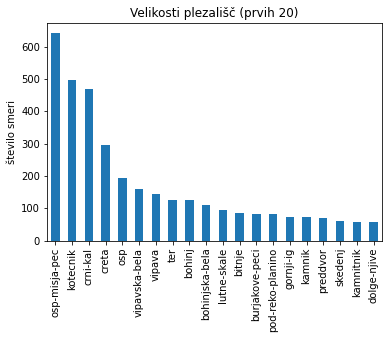

In [2]:
# Ustvarimo tabel različnih smeri in plezališč, v katerih so
smeri_plezalisca = pd.merge(smeri, plezalisca,left_index=True, right_index=True)[['smer', 'plezalisce']].drop_duplicates()
# združimo smeri po posameznih plezališčih in jih preštejemo
smeri_plezalisca.groupby('plezalisce').size().sort_values(ascending=False).head(20).plot.bar(title='Velikosti plezališč (prvih 20)', xlabel='', ylabel="število smeri")
print('Dovžanova soteska: ' , len( smeri_plezalisca[smeri_plezalisca['plezalisce'] == 'dovzanova-soteska']) , '\nKamnitnik: ', len(smeri_plezalisca[smeri_plezalisca['plezalisce'] == 'kamnitnik']))

### Najbolj obiskana plezališča in  smeri
Preštejmo vse vzpone v vsakem plezališču. Velikosti posameznih plezališč sovpadajo z obiskanostjo. Poleg primorske je blazno obiskan še Kotečnik.

<AxesSubplot:title={'center':'Obiskanost plezališč'}, ylabel='število vzponov'>

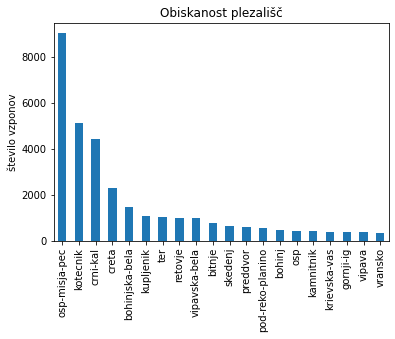

In [3]:
# število vseh obiskov za posamezno plezališče
obiskanosti = plezalisca.groupby('plezalisce').size().sort_values(ascending=False)
obiskanosti.head(20).plot.bar(title='Obiskanost plezališč', xlabel='', ylabel="število vzponov")

<AxesSubplot:title={'center':'Najbolj plezane smeri'}>

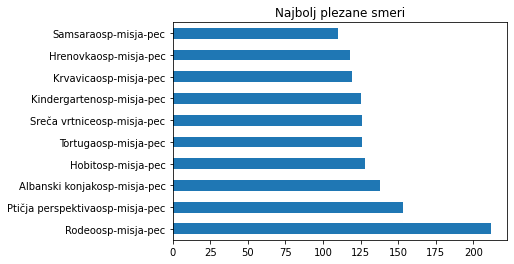

In [4]:
# najbolj plezane smeri
smeri_s_plezalisci.groupby('smer-plezalisce').size().sort_values(ascending=False).head(10).plot.barh(title='Najbolj plezane smeri', xlabel='', ylabel="število vzponov")

Pa še najbolj plezana smer vsakega plezališča.

In [5]:
def najbolj_plezana_smer(df):
    '''
    Vrne največkrat preplezano smer v tabelo df.
    df - DataFrame s stolpcem 'smer'
    '''
    # grupira vzpone glede na smer
    smeri_in_vzponi = df.groupby('smer').size().sort_values(ascending=False)
    # doda v tako obliko, da zlahka dobim prvo vrstico
    smeri_in_vzponi = smeri_in_vzponi.to_frame('st_vzponov').reset_index()
    # smer * st_vzponov
    return smeri_in_vzponi.loc[0]

# za vsako plezališče izbere najbolj plezano smer
najbolj_plezane_smeri = vzponi.groupby('plezalisce').apply(najbolj_plezana_smer)
print("Najbolj pelzana smer v Bohinjski beli je" , najbolj_plezane_smeri.loc['bohinjska-bela']['smer'] ,'.')
najbolj_plezane_smeri

Najbolj pelzana smer v Bohinjski beli je Lady .


,smer,st_vzponov
plezalisce,,
armeko,Za mamico,2
armesko,Gargamel,36
bitenj-potok,Tehnična,11
bitnje,Beli Poper,51
boben,ah mat,4
...,...,...
vrsic,Watschnbam,1
zatrata,Vabljiva golobica,11
zavrnica,Sončna pot,16


## Filozofi
Poiščimo ljudi, ki pišejo najdaljše komentarje.

<AxesSubplot:title={'center':'Skupne dolžine komentarjev'}>

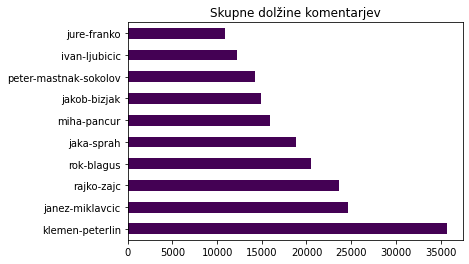

In [6]:
# poberemo samo tiste vzponi, kejr komentar ni prazen
komentarji = vzponi[vzponi['komentar'] == vzponi['komentar']]
komentarji = komentarji[['uporabnik', 'plezalec', 'komentar']]
# dodam stolpec z dolžino
komentarji['dolzina']  = komentarji['komentar'].apply(len)
# dolzine komentarjev
dolzine = komentarji[['uporabnik', 'dolzina']]
dolzine.groupby('uporabnik').sum().sort_values(by='dolzina', ascending= False).head(10).plot.barh(title='Skupne dolžine komentarjev',legend=False, xlabel='', colormap='viridis')

Bolj realno oceno povedo povprečja. Da upoštevamo samo redne plezalce v mišji peči, gledamo samo tiste, ki so spisali vsaj 50 komentarjev.

Število upoštevanih komentatorjev:  39


<AxesSubplot:title={'center':'Povprečne dolžine komentarjev'}>

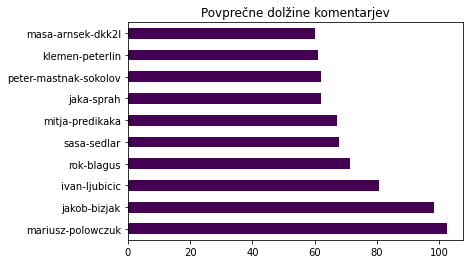

In [7]:
# konstanta, s katero priredim statistično analizo tako, da mi je všeč
minimalno_število_komentarjev = 50

# združim komentarje po uporabnikih
komentarji_na_uporabnika = komentarji.groupby('uporabnik').size().to_frame(name="stevilo")

# uporabniki, ki so zadostkrat komentirali
verodostojni_filozofi = komentarji_na_uporabnika[komentarji_na_uporabnika['stevilo'] > minimalno_število_komentarjev]
verodostojni_filozofi.reset_index(level=0, inplace=True)
verodostojni_filozofi = verodostojni_filozofi['uporabnik'].values #numpy array of str

print('Število upoštevanih komentatorjev: ', len(verodostojni_filozofi))

# dobim tabelo verodostojnih filozofov in dolzin
dolzine.set_index('uporabnik', inplace=True)
ustrezne_dolzine = dolzine.loc[verodostojni_filozofi] # dataframe verodostojen_uporabnik : dolzina

# pogropiram po imenu in povprečim
ustrezne_dolzine.groupby('uporabnik').mean().sort_values(by='dolzina', ascending= False).head(10).plot.barh(title='Povprečne dolžine komentarjev',legend=False, xlabel='', colormap='viridis')


## Analiza težavnosti
V tem poglavju bom analiziral razlike med težavnostmi in zasoljenosti ocen v posameznih plezališčih. Ugotovil bom, kje in katere smeri so najtežje, katera plezališča so ugodna za trening in določil oceno navitosti ocen vsem plezališčem.

### Povprečne ocene
Stran 8a.nu za vsak vzpon zabeleži oceno, ki jo je predlagal uporabnik. Ocena iste smeri se tako razlikuje v različnih vzponih. Zato sem poleg težavnosti (posameznikova ocena) definiral še povprečno oceno vsake smeri (polje *ocena*).

In [8]:
smeri_in_tezavnosti = vzponi[['smer', 'tezavnost', 'ocena']]
# razlika med ocenami pri smeri Divja oma v Kotečniku
print(smeri_in_tezavnosti[smeri_in_tezavnosti['smer']=='Divja oma'])
# print(smeri_in_tezavnosti[smeri_in_tezavnosti['smer']=='Ana Lisa'])
del smeri_in_tezavnosti

            smer tezavnost ocena
id                              
10154  Divja oma        8a   8a+
10892  Divja oma       8a+   8a+
11366  Divja oma       8a+   8a+
12972  Divja oma       8a+   8a+
13397  Divja oma       8a+   8a+
14031  Divja oma        8a   8a+


### Najtežje smeri v sloveniji
Katere smeri so najtežje v Sloveniji?

                     smer  num ocena
0              Massacrate   49   9a+
1          Vicious Circle   49   9a+
2                  Aikula   48    9a
3                 In time   48    9a
4             Pescena ura   48    9a
..                    ...  ...   ...
8                Umetnost   48    9a
9            Xaxid hostel   48    9a
10  Sanjski par extension   48    9a
11            Water world   48    9a
12                Botulin   47   8c+

[13 rows x 3 columns]


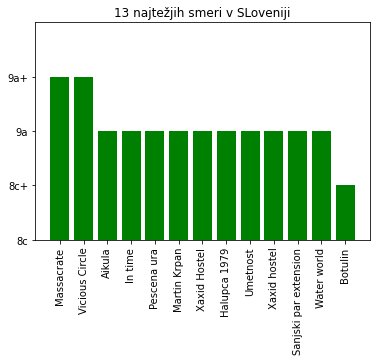

In [9]:
# Glej funcijo:
# ogrodja.ocene()
ocene = ['1a', '1a+', '1b', '1b+', '1c', '1c+', '2a', '2a+', '2b', '2b+', '2c', '2c+', '3a', '3a+', '3b', '3b+', '3c', '3c+', '4a', '4a+', '4b', '4b+', '4c', '4c+', '5a', '5a+', '5b', '5b+', '5c', '5c+', '6a', '6a+', '6b', '6b+', '6c', '6c+', '7a', '7a+', '7b', '7b+', '7c', '7c+', '8a', '8a+', '8b', '8b+', '8c', '8c+', '9a', '9a+'] #, '9b', '9b+', '9c', '9c+']

# matplotlib potrebuje numerične parametre, da lahko
# nariše graf. Zato ocene pretvorimo v cela števila

#Funckija za vrednotenje ocen:
def ocena_v_int(ocena):
    if ocena in ocene:
        return ocene.index(ocena)
    # Lahke smeri nas ne zanimajo (in smeri z oceno 1a v resnici ne obstajajo)
    # Zato lahko vse napake v podatkih slikam v '1a'
    return 0
        
def int_v_oceno(x):
    return ocene[x]

# če me zanimajo najtežje smeri
smeri_z_ocenami = vzponi.groupby('smer').apply(lambda df : (df['tezavnost'].apply(ocena_v_int)).max()).sort_values(ascending=False).to_frame(name='num').reset_index()
smeri_z_ocenami['ocena']=smeri_z_ocenami['num'].apply(int_v_oceno)
# na graf jih bom narisal le 13
smeri_z_ocenami = smeri_z_ocenami.head(13)

print(smeri_z_ocenami)
# isto kot spodej.

# popravljena skala za lepši graf
zamik = smeri_z_ocenami['num'].min() - 1
smeri_z_ocenami['num']-= zamik
ocene_na_grafu = ocene[zamik:]
# print(ocene_na_grafu)
# print(najvecje_ocene)

# https://stackoverflow.com/questions/66093970/pandas-plotting-bar-plot-non-numerical-data/66097436#66097436
# open figure
fig, ax = plt.subplots()
# ensure limits
ax.set_ylim([0,len(ocene_na_grafu)])
ax.bar( x=smeri_z_ocenami['smer'], height=smeri_z_ocenami['num'] ,color='green')
# ensure limits
ax.set_ylim([0,len(ocene_na_grafu)])
# set ticks
ax.set_yticks( list(range(len(ocene_na_grafu))) )
plt.xticks(rotation=90)
# set tick labels
ax.set_yticklabels( ocene_na_grafu )
plt.title('13 najtežjih smeri v SLoveniji')

# mam občutek ,da bom še kdaj definiral kaj takega
del smeri_z_ocenami

Za nadaljno analizo bo pomembno, katera plezališča imajo težke smeri. Poglejmo najtežje ocene v posameznih plezališčih.

Text(0.5, 1.0, 'Najvišje ocene v plezališčih')

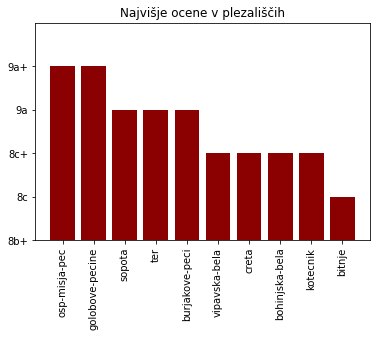

In [10]:
# funckija, ki iz tabele izbeza maximalno oceno
def max_ocena(df):
    df = df['ocena'].apply(ocena_v_int)
    return df.max()
    
# tabela plezališč in največjih ocen v njem
najvecje_ocene = vzponi.groupby('plezalisce').apply(max_ocena).sort_values(ascending=False).head(10).to_frame(name="numericna")

# doda plezalisce kot stolpec
najvecje_ocene.reset_index(inplace=True)


# popravljena skala za lepši graf
zamik = najvecje_ocene['numericna'].min() - 1
najvecje_ocene['numericna']-= zamik
ocene_na_grafu = ocene[zamik:]
# print(ocene_na_grafu)
# print(najvecje_ocene)


# https://stackoverflow.com/questions/66093970/pandas-plotting-bar-plot-non-numerical-data/66097436#66097436
# open figure
fig, ax = plt.subplots()
# ensure limits
ax.set_ylim([0,len(ocene_na_grafu)])
ax.bar( x=najvecje_ocene['plezalisce'], height=najvecje_ocene['numericna'] , color='darkred')
# ensure limits
ax.set_ylim([0,len(ocene_na_grafu)])
# set ticks
ax.set_yticks( list(range(len(ocene_na_grafu))) )
plt.xticks(rotation=90)
# set tick labels
ax.set_yticklabels( ocene_na_grafu )
plt.title('Najvišje ocene v plezališčih')



### Plezališča, primerna za treninge
Za kvaliteten trening je pa bolj od maksimalnosti pomambna raznolikost dovolj težkih smeri. Glejmo število smeri z oceno vsaj 8a.

<AxesSubplot:title={'center':'Število smeri nad 8a'}>

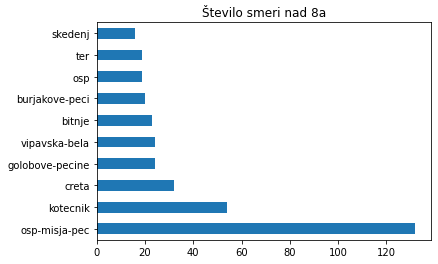

In [11]:
meja = ocena_v_int('8a') # poglej me

def st_tezkih_smeri(df):
    # da ne stejem smeri dvojno
    df = df[['ocena', 'smer']].drop_duplicates()
    # print(df[df['smer']=='Divja oma'])
    smeri = df['ocena'].apply(ocena_v_int).to_frame(name='num')
    tezke_smeri = smeri[smeri['num'] >= meja]
    return len(tezke_smeri)
    


vzponi.groupby('plezalisce').apply(st_tezkih_smeri).sort_values(ascending=False).head(10).plot.barh(title='Število smeri nad 8a', xlabel='')

### Katere smeri so soft? 
V žargonu so smeri, ki so za svojo oceno lahke, torej lažje od ostalih s tako oceno, *soft* (tudi: poceni, zastonj). Lepa značilnost soft smeri je, da jo hitro splezajo plezalci, ki jim sicer ocena predstavlja izziv. Prav tako za tako smer pričakujemo veliko vzponov na pogled *(onsight)* in zlizane stope. 

Če nas zanima, kako soft je smer, je torej smiselno primerjati oceno smeri s plezalčevim povprečjem. Majhen delež vzponov na pogled pa pove, da smer ni poceni (obratno ni nujno res, lahko, da smer ni poceni, ampak je blazno berljiva, recimo Smer krokarjev v Dovžanovi soteski).

Za dobro analizo cene smeri potrebujem dovolj vzponov (zato bodo težke smeri (>8b) verjetno imele slabo ceno). 

**Intuicija za skalo:** V plezalnih krogih plezalec, ki je poleg mnogih *(>10)* smeri z oceno 6b splezal en 7a, velja za 6b plezalca. Plezalec z enim 8a in mnogim 7b po javnem mnenju pleza smeri tja do 7c. V plezalne sposobnosti plezalca, ki pa spleza svoj prvi 9a, pa ne domi nihče, in ima vso pravico, da se kliče 9a plezalec. *(Vir: Mia Krampl)*

Prejšnja linearna skala za primerjanje ocen torej ni relavantna, saj so razlike proti vrhu težavnostne lestvice enake tistim na koncu. Lepe rezultate pa dajejo razne esponentne.


In [12]:
import math
print(f'Francoske ocene: {ocene[30:]}')
def eksponentna_skala(a, dolzina=len(ocene)):
    '''
    Vrne tabelirano funcijo [x^a] za n=1,..., dolzina
    '''
    return [a**(n) for n in range(0,dolzina)]

# globalni:
a = 4
skala = eksponentna_skala(a)


# isto kot zgoraj, samo da zdaj operiramo s skalo
def ocena_v_skalo(ocena):
    if ocena in ocene:
        return skala[ocene.index(ocena)]
    return 0
        
#for i in ocene:
#    print(i, '   -->  ', ocena_v_skalo(i))
    
def skala_v_oceno(x):
    return ocene[skala.index(x)]

def povprecje_ocen(seznam):
    '''
    Vrne povprečje ocen glede na skalo
    '''
   # print('nev list', list(map(ocena_v_skalo, seznam)))
    avrg = sum(list(map(ocena_v_skalo, seznam)))/len(seznam)
    # treba je najdt best match za avrg
    # velja (index_ocene)** i = skala
    prbl_index = math.log(avrg)/math.log(a)
    return ocene[round(prbl_index)]
    

primer = [(['6b+']*10 + ['7a']), 
 (['7b+']*10 + ['8a']),
 (['8c+']*10 + ['9a'])
]
print(povprecje_ocen(primer[0]))
print(povprecje_ocen(primer[1]))
print(povprecje_ocen(primer[2]))

Francoske ocene: ['6a', '6a+', '6b', '6b+', '6c', '6c+', '7a', '7a+', '7b', '7b+', '7c', '7c+', '8a', '8a+', '8b', '8b+', '8c', '8c+', '9a', '9a+']


NameError: name 'potencna_skala' is not defined

Uvajam mero enostavnosti za smeri
$\operatorname{cena}(\text{smer})$, ki ga za smer $S$ definiram kot

$$
   \operatorname{cena}(S) = C\cdot \left (\displaystyle \frac{1}{N}\sum_{v \in V} \min \left (1, \frac{\sigma(p_v)}{\operatorname{ocena}(S)}\right) \cdot \operatorname{poskusi}(v)^{-1}  \right)\cdot \left(  \frac{N'}{N} \right )\cdot \sqrt N
$$
kjer je $N$ število vzponov te smeri, $V$ so vsi vzponi te smeri (z $p_v$ označim plezalca pri vzponu $v \in V$), $\sigma(p)$ je povprečna ocena 5% najtežjih smeri plezalca $p$, \operatorname{poskusi}(v) 1 za *redpoint* ali *toprope*, 5 za *flash* in 10 za *onsight*. $N'$ je število vzponov na pogled. C=100

*Intuicija:* 
- *veliko težja smer od ostalih preplezanih -->  poceni*
- *na polged (na fleš) --> poceni*
- *veliko ponovitev --> bolj poceni kot malo ponovitev*

**Opomba**: računanje sigme za posameznega plezalca traja, zato sem jo že izračunal. Funkcija `sigma_memo()` uporabi izračunane rezultate. Če želite rezultate izračunati sami, zamenjajte `sigma_memo(plezalec)` s `sigma(plezalec)`

In [38]:
# uporabil bom zapis smeri ime+plezalisce, da locim med razlicnimi plezalisci
vzponi['smer-plezalisce'] = vzponi['smer'] + '-'+ vzponi['plezalisce']


# če ne uporabljaš sigma_memo, ki uporabi podatke iz mape
# boš sigma(plezalec) klical večkrat. (pri jaku šprahu 6000krat)
# zato se jo splača zapolnit
memo={}

def sigma(plezalec):
    '''
    Izračuna povprečno* oceno 10% najtežjih vzponov
    
    plezalec - uporabniško ime plezalca
    
    * upošteva razlike med ocenami
    '''
    if not memo.get(plezalec) is None:
        return memo[plezalec]
    
    ustrezni_vzponi = vzponi[vzponi['uporabnik'] == plezalec]
    # ocene uredimo zato, da zlahka vzamem 5%
    ocene = ustrezni_vzponi['ocena'].apply(ocena_v_skalo).sort_values()
    # če ima uporabnik manj kot 10 preplezanih smeri
    # je itak neprezentativen
    # in je zato fajn, da vzamemo 0 kot njegovo povprečje in ga ne upoštevamo
    n_10p = int(0.1 * ocene.size)
    if n_10p <= 0:
        return 0
    ocene = ocene.iloc[:n_10p]
    seznam = ocene.to_numpy()
    memo[plezalec] = sum(seznam) / len(seznam)
    return memo[plezalec]

def izracunaj_sigme(path):
    '''
    Izračuna sigme za vse uporabnike in to shrani v mapo path
    '''
    uporabniki = vzponi['uporabnik'].drop_duplicates().to_numpy()
    sigme=[]
    for uporabnik in uporabniki:
        print(f'Računam sigmo za {uporabnik}..')
        sigme.append(sigma(uporabnik))
    df = pd.DataFrame(data={'uporabnik' : uporabniki, 'sigma': sigme})
    print(df)
    df.to_csv(path)
    scatter
# izracunaj_sigme('/mnt/Podatki/Documents/fmf/programiranje-1/plezalni-vzponi-v-sloveniji/memo/sigme.csv')


def sigma_memo_init():
    '''
    Iz tabele v ../memo/sigme.csv prebere sigme 
    '''
    tabela = pd.read_csv('memo/sigme.csv', index_col=0)
    return tabela.set_index('uporabnik').transpose()

def sigma_memo(plezalec, tabela):
    '''
    Iz tabele tabela prebere sigmo uporanika
    '''
    return tabela[plezalec][0]
        
    
def cena(V):
    '''
    Izračuna ceno smeri
    df - seznam vzponov te smeri
    '''
    # prebere že izračunane podatke
    sigme = sigma_memo_init()
    # print(V)
    N = V.size
    if N == 0:
        # to naj se ne bi zgodilo
        return None
    ocena_smeri = ocena_v_skalo(V.loc[V.index[0]]['ocena']) #dela
    if ocena_smeri == 0:
        print(V.loc[V.index[0]]['ocena'])
        print(V)
    
    vsota = 0
    # vsoto bomo direknto poračunali tako
    # da bomo šli čez vse vzpone
    for i, s in V.iterrows():
        # plezalec tega vzpona p_v:
        # (gledal bom uporabniška imena, ker so enolična)
        plezalec = s['uporabnik']                               #(dela)
        poskusi = 1
        if s['poskusi'] == 'onsight':
            poskusi = 10 
        if s['poskusi'] == 'flash':
            poskusi = 5
        
        vsota += min(1, sigma_memo(plezalec, sigme) / ocena_smeri) * (1/poskusi)
    # N' - št. vzponov na pogled
    N_ = V[V['poskusi']=='onsight'].size
    
    return 100 * (1/N) * vsota * (N_/N) * (N**(1/2))
        
        
    


# ker tudi izračun cen traja, sem jih že izračunal

#cene_smeri = vzponi.groupby('smer-plezalisce').apply(cena).sort_values(ascending=False).to_frame(name="cena")
cene_smeri = pd.read_csv('memo/cene_smeri.csv')
cene_smeri = cene_smeri[['smer-plezalisce', 'cena']]
cene_smeri[cene_smeri['smer-plezalisce'] == 'Karies-osp-misja-pec']

,smer-plezalisce,cena
5429,Karies-osp-misja-pec,0.0


In [44]:
# nekaj znanih smeri:
znane_smeri = ['Karies-osp-misja-pec', # Soft 8b v Ospu
               'Rodeo-osp-misja-pec', # najbolj plezana smer v Mišji (glede na 8a). Ocena je rscatterealna
               'Corto-osp-misja-pec', # hard 8a v Mišji
               'Runo-osp-misja-pec', # konkreten 7b+ v mišji
               'Lady-bohinjska-bela', # pošten 7a+ v Beli
               'Ekosistem-bohinjska-bela', # tehničen 8a v Beli
]
for s in znane_smeri:
    print(cene_smeri[cene_smeri['smer-plezalisce'] == s])

           smer-plezalisce  cena
5429  Karies-osp-misja-pec   0.0
         smer-plezalisce      cena
131  Rodeo-osp-misja-pec  8.120202
          smer-plezalisce      cena
2216  Corto-osp-misja-pec  0.205567
         smer-plezalisce      cena
2023  Runo-osp-misja-pec  0.355195
         smer-plezalisce      cena
167  Lady-bohinjska-bela  7.017678
               smer-plezalisce  cena
3832  Ekosistem-bohinjska-bela   0.0


Cena smeri sicer variira med posamezniki, vendar ti testi primeri kažejo smiselne ocene.

### Katera plezališča so soft?
Za ceno plezališča lahko povprečimo vse smeri v plezališču. 

In [80]:
# dodam stolpec s cenami v vzpone
tmp = cene_smeri.set_index('smer-plezalisce').transpose()

# to ni najlepša rešitev, a dela
def cena_plezalisca(df):
    imena = df['smer-plezalisce'].to_numpy()
    ans = 0
    count = 0
    for ime in imena:
        count += 1
        try:
            ans += tmp[ime]
        except:
            continue
        
    return ans/count


cene_plezalisc = vzponi.groupby('plezalisce').apply(cena_plezalisca).sort_values(by='cena', ascending='False').reset_index()
cene_plezalisc

,plezalisce,cena
0,matvoz,0.000000
1,boben,0.000000
2,zvanov-rob,0.000000
3,umberk,0.002811
4,soder-graben,0.004815
...,...,...
97,preddvor,3.144534
98,retovje,3.324914
99,crni-kal,3.458830
100,kupljenik,3.920951


<AxesSubplot:title={'center':'10 najbolj soft plezališč'}>

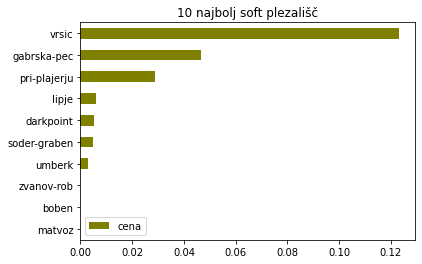

In [92]:
cene_plezalisc.head(10).plot.barh(title="10 najbolj soft plezališč",x='plezalisce', y='cena', color="olive", xlabel='')

<AxesSubplot:title={'center':'20 najmanj soft plezališč'}>

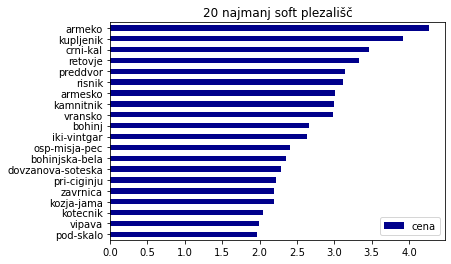

In [97]:
cene_plezalisc.tail(20).plot.barh(title='20 najmanj soft plezališč',x='plezalisce', y='cena', color="darkblue",xlabel='')

## Časovna obremenjenost plezališč
Poglejmo, katere dni je obisk plezališč največji.

<AxesSubplot:title={'center':'Obremenjenosti čez teden'}>

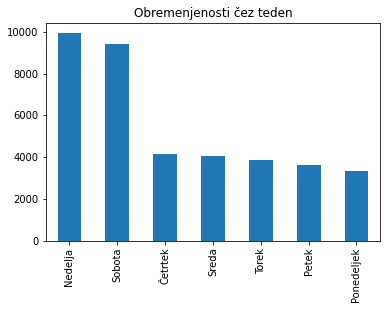

In [107]:
import datetime 
import calendar 

def prevedi_ime_dneva(dan):
    slovar = {
    'Sunday' : 'Nedelja',
    'Monday' : 'Ponedeljek',
    'Tuesday' : 'Torek',
    'Wednesday' : 'Sreda',
    'Thursday' : 'Četrtek',
    'Friday' : 'Petek',
    'Saturday' : 'Sobota'}
    return slovar[dan]

# https://www.geeksforgeeks.org/python-program-to-find-day-of-the-week-for-a-given-date/?ref=rp
def findDay(date): 
    born = datetime.datetime.strptime(date, '%m/%d/%Y').weekday() 
    return prevedi_ime_dneva(calendar.day_name[born]) 
vzponi['dan'] = vzponi['datum'].apply(findDay)
vzponi.groupby('dan').size().sort_values(ascending=False).head(20).plot.bar(title='Obremenjenosti čez teden', xlabel='', ylabel="")

Kako se pa spreminja število obiskov čez leta?

<AxesSubplot:xlabel='leto'>

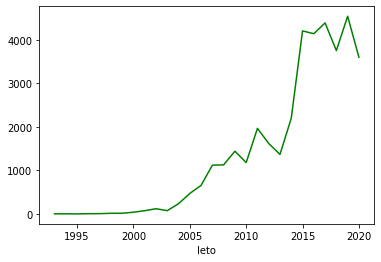

In [115]:
# najprej poračunajmo leta
def datum_v_leto(datum):
    return int(datum.split('/')[2])
vzponi['leto'] = vzponi['datum'].apply(datum_v_leto)
vzponi.groupby('leto').size().plot(color='green')

## Odvisnost števila vzponov od ocene
Za konec poglejmo še, kako je število vzponov odvisno od ocene posamezne smeri. Spet bom uporabil linearno skalo.

<ipython-input-158-1dfcd816abbe>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ['0','1a', '2c', '4b', '6a', '7c', '9b+'] )


[('1a', 0),
 ('1a+', 1),
 ('1b', 2),
 ('1b+', 3),
 ('1c', 4),
 ('1c+', 5),
 ('2a', 6),
 ('2a+', 7),
 ('2b', 8),
 ('2b+', 9),
 ('2c', 10),
 ('2c+', 11),
 ('3a', 12),
 ('3a+', 13),
 ('3b', 14),
 ('3b+', 15),
 ('3c', 16),
 ('3c+', 17),
 ('4a', 18),
 ('4a+', 19),
 ('4b', 20),
 ('4b+', 21),
 ('4c', 22),
 ('4c+', 23),
 ('5a', 24),
 ('5a+', 25),
 ('5b', 26),
 ('5b+', 27),
 ('5c', 28),
 ('5c+', 29),
 ('6a', 30),
 ('6a+', 31),
 ('6b', 32),
 ('6b+', 33),
 ('6c', 34),
 ('6c+', 35),
 ('7a', 36),
 ('7a+', 37),
 ('7b', 38),
 ('7b+', 39),
 ('7c', 40),
 ('7c+', 41),
 ('8a', 42),
 ('8a+', 43),
 ('8b', 44),
 ('8b+', 45),
 ('8c', 46),
 ('8c+', 47),
 ('9a', 48),
 ('9a+', 49)]

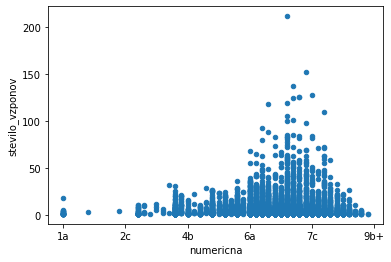

In [158]:
# število vzponov na smer
smeri_st = vzponi.groupby('smer-plezalisce').size().to_frame(name='stevilo_vzponov').reset_index()
smeri_ocene = vzponi.groupby('smer-plezalisce').apply(lambda x : x['ocena'].to_numpy()[0]).to_frame('ocena').reset_index()
smeri = pd.merge(smeri_st, smeri_ocene)
smeri['numericna']= smeri['ocena'].apply(lambda x : ocena_v_int(x))
ax = smeri.plot.scatter(x='numericna', y='stevilo_vzponov')
# ax.set_xticks( list(range(len(ocene))) )
ax.set_xticklabels( ['0','1a', '2c', '4b', '6a', '7c', '9b+'] )
[(ocene[i], i) for i in range(0, len(ocene))]

# Izsledki
- Čez vikend je gužva povsod
- Karies je res soft
- Zdaj se več pleza